In [1]:
#!/usr/bin/env python3
# Demo data acquisition and plot in Jupyter notebook  
import serial
from IPython.display import display
from gds_scpi import scpi_acq_mem_head
from numpy import linspace

# FIXME add command line option parsing here

In [2]:
# FIXME move declaration of the serial object to an _init_() method in a
# new class. With ser declared here, ser object has to be passed to the
# functions that use it.

# configure port instance, but don't auto-open
ser = serial.Serial(None, baudrate=38400,
                    bytesize=8, parity ='N', stopbits=1,
                    xonxoff=False, dsrdtr=False, rtscts=False,
                    timeout=2)

# FIXME use list_ports() in serial.tools for port selection
# set a fixed port path for now
PORT = '/dev/ttyACM0'
# PORT = '/dev/ttyACM1'
ser.port = PORT

In [3]:
channel = 1
print('request acquisition header and data for channel', channel)

# request the acquisition header and data
# this may take seconds for >=100k points
acq_dir, acq_data = scpi_acq_mem_head(ser, channel)

print('got', acq_dir['Memory Length'], 'points')

request acquisition header and data for channel 1
got 100000.0 points


In [4]:
# Vertical counts per division
COUNT_PER_DIV = 25
VERT_DIVS = 8
VERT_MAX = +4
VERT_MIN = -4
# Screen division grid
HORIZ_DIVS = 10
HORIZ_MIN = -5
HORIZ_MAX = +5

In [5]:
# calculate time scaling and position
time_start = (HORIZ_MIN * acq_dir['Horizontal Scale']
             + acq_dir['Horizontal Position'])
time_step = (HORIZ_DIVS * acq_dir['Horizontal Scale']
             / acq_dir['Memory Length'])
vert_multi = acq_dir['Vertical Scale'] / COUNT_PER_DIV

In [6]:
# build list of scaled points
scaled_x = []
scaled_y = []
for n, adc in enumerate(acq_data):
    scaled_x.append(time_step * n + time_start)
    scaled_y.append(adc * vert_multi)

In [7]:
# calculate y axis min and max same as screen
y_min = VERT_MIN * acq_dir['Vertical Scale'] + acq_dir['Vertical Position']
y_max = VERT_MAX * acq_dir['Vertical Scale'] + acq_dir['Vertical Position']
y_ticks = linspace(y_min, y_max, VERT_DIVS+1)

In [8]:
# get x axis min and max from scaled_x[]
x_min = scaled_x[0]
x_max = scaled_x[-1]

# define x tick marks, major ticks get labeled
x_ticks_major = [x_min, acq_dir['Horizontal Position'], x_max]
x_ticks_minor = linspace(x_min, x_max, HORIZ_DIVS+1)

<function matplotlib.pyplot.show(close=None, block=None)>

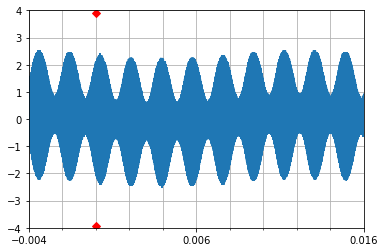

In [9]:
# use inline plotting
%matplotlib inline

# or default interactive
# %matplotlib

from matplotlib import pyplot as plt 

# new plot object instance
fig, ax = plt.subplots()
# add line plot from scaled data
ax.plot(scaled_x, scaled_y, linewidth=1)
# plot ranges
ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max)
# gridding
ax.set_yticks(y_ticks)
ax.set_xticks(x_ticks_major)
ax.set_xticks(x_ticks_minor, minor=True)
ax.grid(axis='both', which='both')
# add trigger markers
ax.plot(0, y_max * 0.98, 'Dr')
ax.plot(0, y_min * 0.98, 'Dr')
# then show
plt.show